In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from tqdm import tqdm

# Set random seeds
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [7]:
# Preprocessing functions
def clean(text) -> str:
  """
  Processes the text based on rules.

  Parameters
  ----------
  text : str
    The string to process.

  Returns
  -------
  str
    The processed string.
  """
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

def remove_numbers(text = str) -> str:
  """
  Removes numbers from the text.

  Parameters
  ----------
  text : str
    The string to remove numbers from.

  Returns
  -------
  str
    The string with numbers removed.
  """

  # Remove numbers
  return re.sub(r'\b\d+\b', '', text)

def remove_punctuation(text = str) -> str:
  """
  Removes punctuation from the text.

  Parameters
  ----------
  text : str
    The string to remove punctuation from.

  Returns
  -------
  str
    The string with punctuation removed.
  """

  # Remove punctuation
  return re.sub(r'[^\w\s]', '', text)

def lemmatize(text = str) -> str:
  """
  Lemmatizes the text.

  Parameters
  ----------
  text : str
    The string to lemmatize.

  Returns
  -------
  str
    The lemmatized string.
  """

  # Helper function for part of speech
  def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

  # Initialize lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Get tokens
  words = text.split()

  # Get part of speech
  pos_tags = pos_tag(words)

  # Lemmatize each word
  words_lemmatize = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

  # Join words back together
  return " ".join(words_lemmatize)

def stemming(text = str) -> str:
  """
  Stems the text.

  Parameters
  ----------
  text : str
    The string to stem.

  Returns
  -------
  str
    The stemmed string.
  """

  # Initialize stemmer
  stemmer = PorterStemmer()

  # Get tokens
  words = text.split()

  # Stem each word
  words_stem = [stemmer.stem(word) for word in words]

  # Join words back together
  return " ".join(words_stem)

def preprocessing(df = pd.DataFrame, preprocessing_functions = list) -> pd.DataFrame:
  """
  Preprocesses the text in the dataframe.

  Parameters
  ----------
  df : pd.DataFrame
    The dataframe to preprocess.
  preprocessing_functions : list
    The list of preprocessing functions to apply.

  Returns
  -------
  pd.DataFrame
    The preprocessed dataframe.
  """

  # Initialize dataframe
  df_copy = df.copy()

  # Apply preprocessing functions
  for preprocessing_function in preprocessing_functions:
    df_copy.map(preprocessing_function)

  return df_copy

In [8]:
# Evaluation functions

def classifier_metrics(y_true = list, y_pred = list, model_name = "Model"):
  """
  Prints the metrics for a classifier.

  Parameters
  ----------
  y_true : list
    The true labels.
  y_pred : list
    The predicted labels.
  model_name : str
    The name of the model.

  Returns
  -------
  None
  """

  # Print metrics
  print(model_name)
  print("Accuracy: ", accuracy_score(y_true, y_pred))
  print("Precision: ", precision_score(y_true, y_pred, pos_label = 'sports'))
  print("Recall: ", recall_score(y_true, y_pred, pos_label = 'sports'))
  print("F1 score: ", f1_score(y_true, y_pred, pos_label = 'sports'))
  print()

def plot_roc_curve(y_true = list, y_pred_prob = list, model_name = "Model"):
  """
  Plots the ROC curve for a binary classifier.

  Parameters
  ----------
  y_true : list
      The true labels.
  y_pred_prob : list
      The predicted probabilities.
  model_name : str
      The name of the model.

  Returns
  -------
  None
  """

  # Binarize string labels
  lb = LabelBinarizer(pos_label = 1)
  y_true = lb.fit_transform(y_true)

  # Compute the ROC curve and AUC score
  fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
  roc_auc = auc(fpr, tpr)

  # Plot the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color = 'blue', lw = 2, label = f"{model_name} (AUC = {roc_auc:.2f})")
  plt.plot([0, 1], [0, 1], color = 'black', lw = 2)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) Curve")
  plt.legend(loc = "lower right")
  plt.grid(alpha = 0.7)
  plt.show()

In [ ]:
# Pipeline function
def pipeline(train = pd.DataFrame, test = pd.DataFrame, preprocessing_functions = tuple, mindf = int, model = str, k = int, classifier = str, regularization = "L1") -> float:
  """
  Runs the pipeline for a given set of parameters.

  Parameters
  ----------
  train : pd.DataFrame
    The training set.
  test : pd.DataFrame
    The testing set.
  preprocessing_functions : tuple
    The tuple of preprocessing functions to apply.
  mindf : int
    The minimum document frequency.
  model : str
    The model to use.
  k : int
    The number of components to use.
  classifier : str
    The classifier to use.
  regularization : str
    The regularization to use. Used only for logistic regression.

  Returns
  -------
  accuracy : float
    The accuracy of the model.
  best_param : float
    The gamma parameter of the model. Used for SVM and logistic regression.
  """

  ### Loading Data
  # Preprocessing
  preprocessing_functions = list(preprocessing_functions)
  X_train = preprocessing(train, preprocessing_functions)
  X_test = preprocessing(test, preprocessing_functions)

  ### Feature Extraction
  # Convert to TF-IDF Matrix
  count_vect = CountVectorizer(stop_words = 'english', min_df = mindf)
  tfidf_transformer = TfidfTransformer()
  X_train_counts = count_vect.fit_transform(X_train['full_text'])
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
  X_test_counts = count_vect.transform(X_test['full_text'])
  X_test_tfidf = tfidf_transformer.transform(X_test_counts)

  ### Dimensionality Reduction
  # LSI Model
  if model == "LSI":
    svd = TruncatedSVD(n_components = k, random_state = 42)
    X_train_reduced = svd.fit_transform(X_train_tfidf)
    X_test_reduced = svd.transform(X_test_tfidf)
  # NMF Model
  elif model == "NMF":
    nmf = NMF(n_components = k, init = 'random', random_state = 42)
    W_train = nmf.fit_transform(X_train_tfidf)
    H = nmf.components_
    X_train_reduced = W_train
    W_test = nmf.transform(X_test_tfidf)
    X_test_reduced = W_test
  else:
    raise ValueError("Invalid model name")

  ### Classifier

  # Parameter grid for SVM and Logistic Regression
  param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}
  best_param = None # Default best gamma to none

  # SVM Model
  if classifier == "SVM":
    # Perform 5-fold cross validation to choose best gamma
    model = LinearSVC(random_state = 42)

    # Perform grid search to find best parameter
    grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
    grid_search.fit(X_train_reduced, train['root_label'])

    # Get best parameter
    best_param = grid_search.best_params_['C']

    # Fit model using best parameter
    best_model = LinearSVC(C = best_param, random_state = 42)
    best_model.fit(X_train_reduced, train['root_label'])
    y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
    y_pred_best_svm = y_pred_best # Keep for McNemar's test
    y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).decision_function(X_test_reduced)

    # Get accuracy
    accuracy = accuracy_score(test['root_label'], y_pred_best)

  # Logistic Regression Model
  elif classifier == "Logistic Regression":
    if regularization == "L1":
      # L1 regularization
      model = LogisticRegression(random_state = 42, penalty = 'l1', solver = 'liblinear')
      grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
      grid_search.fit(X_train_reduced, train['root_label'])

      # Extract best parameter
      best_param = grid_search.best_params_['C']

      # Fit model using best parameter
      best_model = LogisticRegression(C = best_param, random_state = 42, penalty = 'l1', solver = 'liblinear')
      best_model.fit(X_train_reduced, train['root_label'])
      y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
      y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).predict_proba(X_test_reduced)[:, 1]

      # Get accuracy
      accuracy = accuracy_score(test['root_label'], y_pred_best)

    elif regularization == "L2":
      # L2 regularization
      model = LogisticRegression(random_state = 42, penalty = 'l2')
      grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
      grid_search.fit(X_train_reduced, train['root_label'])

      # Extract best parameter
      best_param = grid_search.best_params_['C']

      # Fit model using best parameter
      best_model = LogisticRegression(C = best_param, random_state = 42, penalty = 'l2')
      best_model.fit(X_train_reduced, train['root_label'])
      y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
      y_pred_best_lr = y_pred_best # Keep for McNemar's test
      y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).predict_proba(X_test_reduced)[:, 1]

      # Get accuracy
      accuracy = accuracy_score(test['root_label'], y_pred_best)

    else:
      raise ValueError("Invalid regularization name")

  # Naive Bayes Classifier
  elif classifier == "Naive Bayes":
    model = GaussianNB()
    model.fit(X_train_reduced, train['root_label'])
    y_pred = model.predict(X_test_reduced)
    y_pred_prob = model.predict_proba(X_test_reduced)[:, 1]

    # Get accuracy
    accuracy = accuracy_score(test['root_label'], y_pred)

  return accuracy, best_param

In [ ]:
# Set random seeds
np.random.seed(42)
random.seed(42)

# Global variables
df = pd.read_csv("Project1-ClassificationDataset.csv")
training, testing = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)

# Test arguments
train = training
test = testing
preprocessing_functions = (clean, remove_numbers, remove_punctuation)
mindf = 3
model = "LSI"
model = "NMF"
k = 5
# classifier = "Logistic Regression"
# classifier = "Logistic Regression"
classifier = "Naive Bayes"
regularization = "L1"
# regularization = "L2"

pipeline(train, test, preprocessing_functions, mindf, model, k, classifier, regularization)

(0.8663793103448276, None)

In [ ]:
# Let combinations be keys and accuracies (and regularization if applicable) be values
combinations = []
accuracy_values = []

# Hyperparameters for pipeline comparison
# Feature extraction
mindfs = [2, 3, 4, 5]
preprocessing_functions_list = [(clean, remove_numbers, remove_punctuation, lemmatize), (clean, remove_numbers, remove_punctuation, stemming)]
# preprocessing_functions_list = [(clean, remove_numbers, remove_punctuation)]

# Dimensionality Reduction
models = ["LSI", "NMF"]
components = [5, 30, 100]

# Classifier
classifiers = ["SVM", "Logistic Regression"]
regularizations = ["L1", "L2"]

for mindf in mindfs:
  for preprocessing_functions in preprocessing_functions_list:
    for model in models:
      for k in components:
        for classifier in classifiers:
          if classifier == "Logistic Regression":
            for regularization in regularizations:
              combinations.append((mindf, preprocessing_functions, model, k, classifier, regularization))
          else:
            combinations.append((mindf, preprocessing_functions, model, k, classifier))

for combination in tqdm(combinations, desc = "Processing combinations"):
  mindf = combination[0]
  preprocessing_functions = combination[1]
  model = combination[2]
  k = combination[3]
  classifier = combination[4]
  if classifier == "Logistic Regression":
    regularization = combination[5]
    accuracy_values.append(pipeline(train, test, preprocessing_functions, mindf, model, k, classifier, regularization))
  else:
    accuracy_values.append(pipeline(train, test, preprocessing_functions, mindf, model, k, classifier))

# Dictionary to store combinations and accuracy/regularization
combinations_accuracy = {}

# Add key-value pairs dynamically in a loop
for key, value in zip(combinations, accuracy_values):
    combinations_accuracy[key] = value


Processing combinations:  10%|█         | 15/144 [27:15<4:13:12, 117.77s/it]/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1243: ConvergenceW

In [ ]:
# Store combinations and accuracies/regularization in a txt file (above code takes ~3.5 hours to run)
with open("accuracy_values.txt", "w") as f:
  f.write(str(accuracy_values))

In [ ]:
with open("combinations.txt", "w") as f:
  f.write(str(combinations))

In [ ]:
# Dictionary to store combinations and accuracy/regularization
combinations_accuracy = {}

# Add key-value pairs dynamically in a loop
for key, value in zip(combinations, accuracy_values):
    combinations_accuracy[key] = value

In [ ]:
# Store dictionary
with open("combinations_accuracy.txt", "w") as f:
  f.write(str(combinations_accuracy))

In [9]:
# Let combinations be keys and accuracies (and regularization if applicable) be values
combinations = []
accuracy_values = []

# Hyperparameters for pipeline comparison
# Feature extraction
mindfs = [2, 3, 4, 5]
preprocessing_functions_list = [(clean, remove_numbers, remove_punctuation, lemmatize), (clean, remove_numbers, remove_punctuation, stemming)]
# preprocessing_functions_list = [(clean, remove_numbers, remove_punctuation)]

# Dimensionality Reduction
models = ["LSI", "NMF"]
components = [5, 30, 100]

# Classifier
classifiers = ["SVM", "Logistic Regression"]
regularizations = ["L1", "L2"]

for mindf in mindfs:
  for preprocessing_functions in preprocessing_functions_list:
    for model in models:
      for k in components:
        for classifier in classifiers:
          if classifier == "Logistic Regression":
            for regularization in regularizations:
              combinations.append((mindf, preprocessing_functions, model, k, classifier, regularization))
          else:
            combinations.append((mindf, preprocessing_functions, model, k, classifier))

# Load in accuracy list
with open("accuracy_values.txt", "r") as f:
    accuracy_values = eval(f.read())

# Dictionary to store combinations and accuracy/regularization
combinations_accuracy = {}

# Add key-value pairs dynamically in a loop
for key, value in zip(combinations, accuracy_values):
    combinations_accuracy[key] = value

In [46]:
# Sort dictionary by accuracy
sorted_items = sorted(combinations_accuracy.items(), key = lambda item: item[1][0], reverse = True)

# Get top 5 combinations
top_5 = sorted_items[:5]
top_5_models = [t[0] for t in top_5]
top_5_models

[(5,
  (<function __main__.clean(text) -> str>,
   <function __main__.remove_numbers(text=<class 'str'>) -> str>,
   <function __main__.remove_punctuation(text=<class 'str'>) -> str>,
   <function __main__.lemmatize(text=<class 'str'>) -> str>),
  'LSI',
  100,
  'SVM'),
 (5,
  (<function __main__.clean(text) -> str>,
   <function __main__.remove_numbers(text=<class 'str'>) -> str>,
   <function __main__.remove_punctuation(text=<class 'str'>) -> str>,
   <function __main__.stemming(text=<class 'str'>) -> str>),
  'LSI',
  100,
  'SVM'),
 (4,
  (<function __main__.clean(text) -> str>,
   <function __main__.remove_numbers(text=<class 'str'>) -> str>,
   <function __main__.remove_punctuation(text=<class 'str'>) -> str>,
   <function __main__.lemmatize(text=<class 'str'>) -> str>),
  'LSI',
  100,
  'Logistic Regression',
  'L1'),
 (4,
  (<function __main__.clean(text) -> str>,
   <function __main__.remove_numbers(text=<class 'str'>) -> str>,
   <function __main__.remove_punctuation(text=<

In [39]:
# Modified pipieline to plot metrics
def pipeline_metrics(train = pd.DataFrame, test = pd.DataFrame, preprocessing_functions = tuple, mindf = int, model = str, k = int, classifier = str, regularization = "L1") -> float:
  """
  Runs the pipeline for a given set of parameters and plots the metrics.

  Parameters
  ----------
  train : pd.DataFrame
    The training set.
  test : pd.DataFrame
    The testing set.
  preprocessing_functions : tuple
    The tuple of preprocessing functions to apply.
  mindf : int
    The minimum document frequency.
  model : str
    The model to use.
  k : int
    The number of components to use.
  classifier : str
    The classifier to use.
  regularization : str
    The regularization to use. Used only for logistic regression.

  Returns
  -------
  accuracy : float
    The accuracy of the model.
  best_param : float
    The gamma parameter of the model. Used for SVM and logistic regression.
  """

  ### Loading Data
  # Preprocessing
  preprocessing_functions = list(preprocessing_functions)
  X_train = preprocessing(train, preprocessing_functions)
  X_test = preprocessing(test, preprocessing_functions)

  ### Feature Extraction
  # Convert to TF-IDF Matrix
  count_vect = CountVectorizer(stop_words = 'english', min_df = mindf)
  tfidf_transformer = TfidfTransformer()
  X_train_counts = count_vect.fit_transform(X_train['full_text'])
  X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
  X_test_counts = count_vect.transform(X_test['full_text'])
  X_test_tfidf = tfidf_transformer.transform(X_test_counts)

  ### Dimensionality Reduction
  # LSI Model
  if model == "LSI":
    svd = TruncatedSVD(n_components = k, random_state = 42)
    X_train_reduced = svd.fit_transform(X_train_tfidf)
    X_test_reduced = svd.transform(X_test_tfidf)
  # NMF Model
  elif model == "NMF":
    nmf = NMF(n_components = k, init = 'random', random_state = 42)
    W_train = nmf.fit_transform(X_train_tfidf)
    H = nmf.components_
    X_train_reduced = W_train
    W_test = nmf.transform(X_test_tfidf)
    X_test_reduced = W_test
  else:
    raise ValueError("Invalid model name")

  ### Classifier

  # Parameter grid for SVM and Logistic Regression
  param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}
  best_param = None # Default best gamma to none

  # SVM Model
  if classifier == "SVM":
    # Perform 5-fold cross validation to choose best gamma
    model = LinearSVC(random_state = 42)

    # Perform grid search to find best parameter
    grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
    grid_search.fit(X_train_reduced, train['root_label'])

    # Get best parameter
    best_param = grid_search.best_params_['C']

    # Fit model using best parameter
    best_model = LinearSVC(C = best_param, random_state = 42)
    best_model.fit(X_train_reduced, train['root_label'])
    y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
    y_pred_best_svm = y_pred_best # Keep for McNemar's test
    y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).decision_function(X_test_reduced)

    # Get accuracy
    accuracy = accuracy_score(test['root_label'], y_pred_best)

    # Evaluate SVM model
    classifier_metrics(test['root_label'], y_pred_best, "SVM model (gamma = " + str(best_param) + ")")
    print("Confusion matrix for SVM model (gamma = " + str(best_param) + "):")
    cm = confusion_matrix(test['root_label'], y_pred_best)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model.classes_)
    disp.plot()
    plt.show()
    print()
    plot_roc_curve(test['root_label'], y_pred_best_prob, "SVM model (gamma = " + str(best_param) + ")")

  # Logistic Regression Model
  elif classifier == "Logistic Regression":
    if regularization == "L1":
      # L1 regularization
      model = LogisticRegression(random_state = 42, penalty = 'l1', solver = 'liblinear')
      grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
      grid_search.fit(X_train_reduced, train['root_label'])

      # Extract best parameter
      best_param = grid_search.best_params_['C']

      # Fit model using best parameter
      best_model = LogisticRegression(C = best_param, random_state = 42, penalty = 'l1', solver = 'liblinear')
      best_model.fit(X_train_reduced, train['root_label'])
      y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
      y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).predict_proba(X_test_reduced)[:, 1]

      # Get accuracy
      accuracy = accuracy_score(test['root_label'], y_pred_best)

      # Metrics
      classifier_metrics(test['root_label'], y_pred_best, "Logistic Regression with l1 penalty and gamma = " + str(best_param) + ")")
      print("Confusion matrix for logistic regression with penalty = l1:")
      cm = confusion_matrix(test['root_label'], y_pred_best)
      disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model.classes_)
      disp.plot()
      plt.show()
      print()
      plot_roc_curve(test['root_label'], y_pred_best_prob, "Logistic Regression with l1 penalty and gamma = " + str(best_param) + ")")

    elif regularization == "L2":
      # L2 regularization
      model = LogisticRegression(random_state = 42, penalty = 'l2')
      grid_search = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
      grid_search.fit(X_train_reduced, train['root_label'])

      # Extract best parameter
      best_param = grid_search.best_params_['C']

      # Fit model using best parameter
      best_model = LogisticRegression(C = best_param, random_state = 42, penalty = 'l2')
      best_model.fit(X_train_reduced, train['root_label'])
      y_pred_best = best_model.fit(X_train_reduced, train['root_label']).predict(X_test_reduced)
      y_pred_best_lr = y_pred_best # Keep for McNemar's test
      y_pred_best_prob = best_model.fit(X_train_reduced, train['root_label']).predict_proba(X_test_reduced)[:, 1]

      # Get accuracy
      accuracy = accuracy_score(test['root_label'], y_pred_best)

      # Metrics
      classifier_metrics(test['root_label'], y_pred_best, "Logistic Regression with l2 penalty and gamma = " + str(best_param) + ")")
      print("Confusion matrix for logistic regression with penalty = l2:")
      cm = confusion_matrix(test['root_label'], y_pred_best)
      disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_model.classes_)
      disp.plot()
      plt.show()
      print()
      plot_roc_curve(test['root_label'], y_pred_best_prob, "Logistic Regression with l1 penalty and gamma = " + str(best_param) + ")")

    else:
      raise ValueError("Invalid regularization name")

  # Naive Bayes Classifier
  elif classifier == "Naive Bayes":
    model = GaussianNB()
    model.fit(X_train_reduced, train['root_label'])
    y_pred = model.predict(X_test_reduced)
    y_pred_prob = model.predict_proba(X_test_reduced)[:, 1]

    # Get accuracy
    accuracy = accuracy_score(test['root_label'], y_pred)

    # Metrics
    classifier_metrics(test['root_label'], y_pred, "Naive Bayes")
    print("Confusion matrix for naive bayes:")
    cm = confusion_matrix(test['root_label'], y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    disp.plot()
    plt.show()
    print()
    plot_roc_curve(test['root_label'], y_pred_prob, "Naive Bayes")

  return accuracy, best_param

Processing top 5 combinations:   0%|          | 0/5 [00:00<?, ?it/s]

SVM model (gamma = 10)
Accuracy:  0.9712643678160919
Precision:  0.978021978021978
Recall:  0.967391304347826
F1 score:  0.9726775956284153

Confusion matrix for SVM model (gamma = 10):


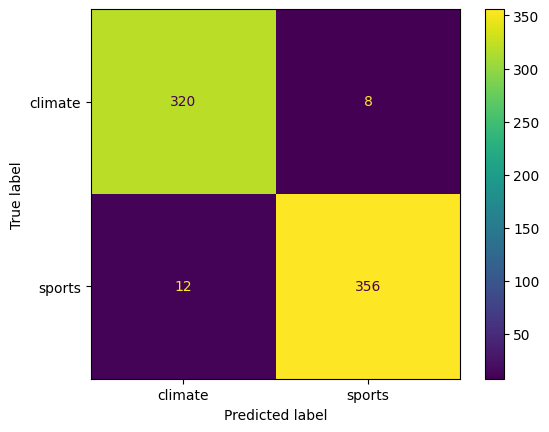

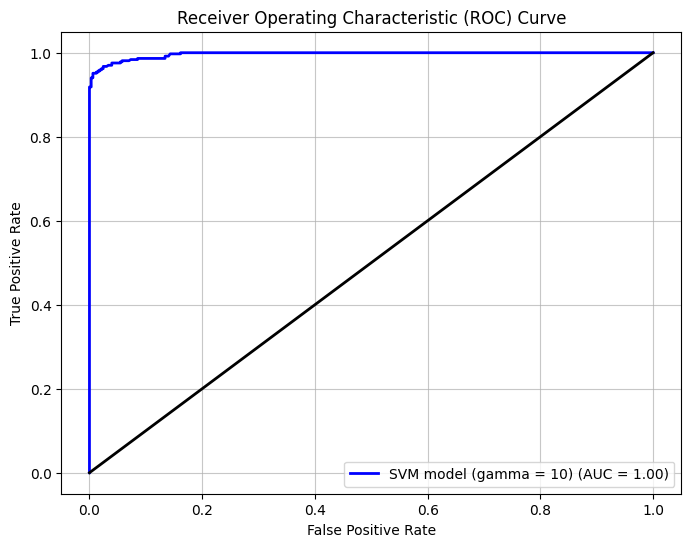

Processing top 5 combinations:  20%|██        | 1/5 [01:53<07:32, 113.15s/it]

SVM model (gamma = 10)
Accuracy:  0.9712643678160919
Precision:  0.978021978021978
Recall:  0.967391304347826
F1 score:  0.9726775956284153

Confusion matrix for SVM model (gamma = 10):


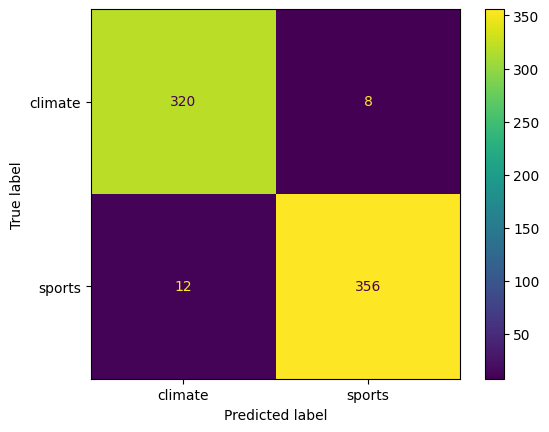

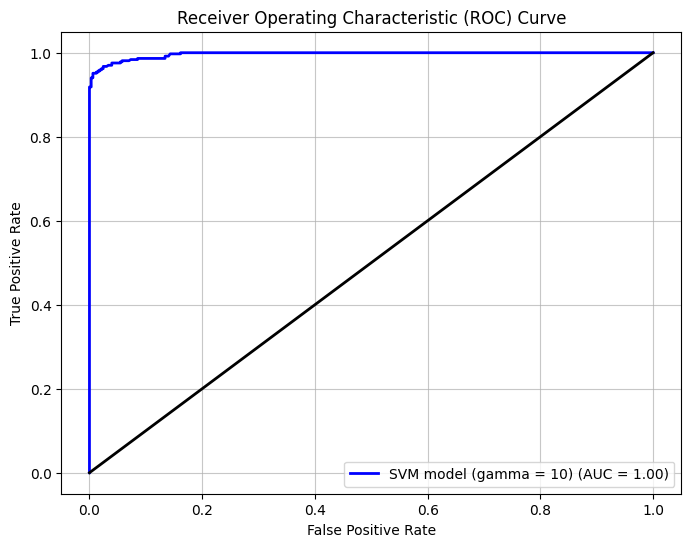

Processing top 5 combinations:  40%|████      | 2/5 [02:47<03:56, 78.72s/it] 

Logistic Regression with l1 penalty and gamma = 10)
Accuracy:  0.9698275862068966
Precision:  0.977961432506887
Recall:  0.9646739130434783
F1 score:  0.9712722298221614

Confusion matrix for logistic regression with penalty = l1:


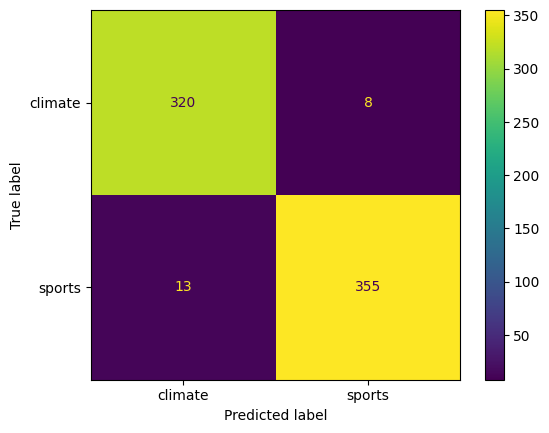

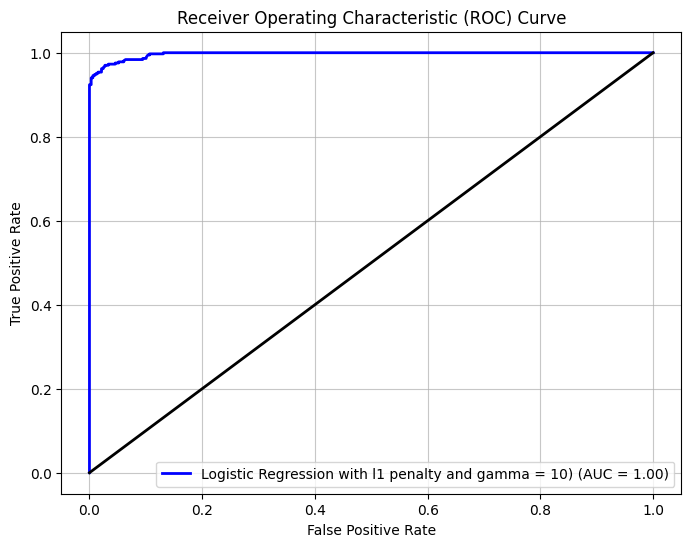

Processing top 5 combinations:  60%|██████    | 3/5 [05:08<03:34, 107.18s/it]

Logistic Regression with l1 penalty and gamma = 10)
Accuracy:  0.9698275862068966
Precision:  0.977961432506887
Recall:  0.9646739130434783
F1 score:  0.9712722298221614

Confusion matrix for logistic regression with penalty = l1:


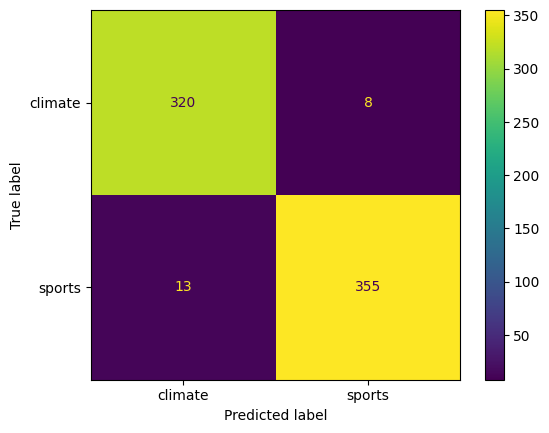

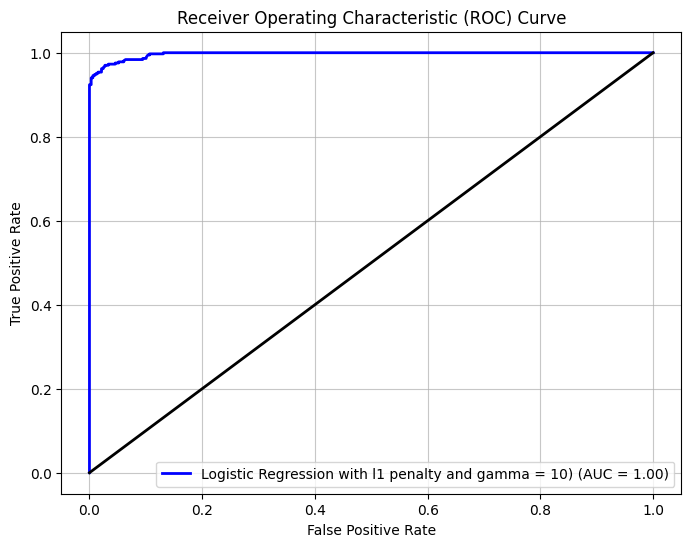

Processing top 5 combinations:  80%|████████  | 4/5 [05:59<01:24, 84.96s/it] 

Logistic Regression with l2 penalty and gamma = 1000)
Accuracy:  0.9698275862068966
Precision:  0.9753424657534246
Recall:  0.967391304347826
F1 score:  0.9713506139154161

Confusion matrix for logistic regression with penalty = l2:


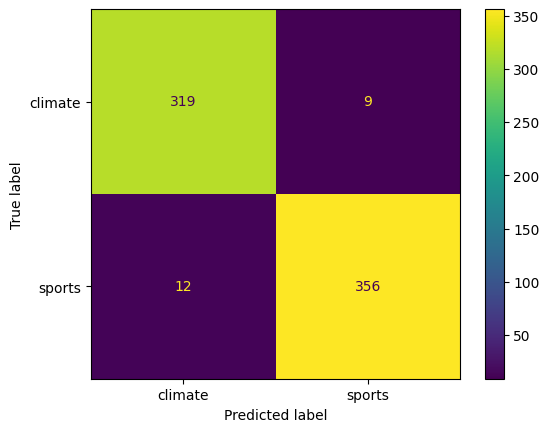

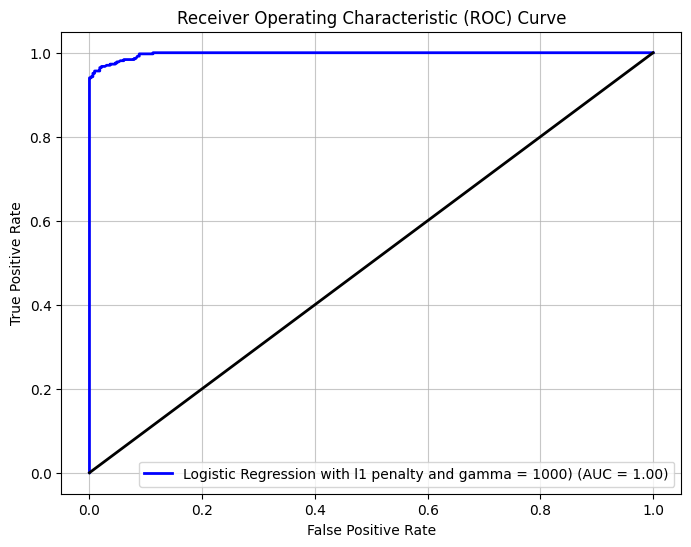

Processing top 5 combinations: 100%|██████████| 5/5 [07:42<00:00, 92.47s/it]


In [41]:
# Set random seeds
np.random.seed(42)
random.seed(42)

# Global variables
df = pd.read_csv("Project1-ClassificationDataset.csv")
training, testing = train_test_split(df[["full_text", "root_label"]], test_size = 0.2)

# Test arguments
train = training
test = testing

for combination in tqdm(top_5_models, desc = "Processing top 5 combinations"):
  mindf = combination[0]
  preprocessing_functions = combination[1]
  model = combination[2]
  k = combination[3]
  classifier = combination[4]
  if classifier == "Logistic Regression":
    regularization = combination[5]
    pipeline_metrics(train, test, preprocessing_functions, mindf, model, k, classifier, regularization)
  else:
    pipeline_metrics(train, test, preprocessing_functions, mindf, model, k, classifier)